<a href="https://colab.research.google.com/github/danielturg/Road2_AI_Course_Scripts/blob/main/3DObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Functions:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import shutil
import random

def create_torus(width, height, depth, major_radius, minor_radius, center=None):
    if center is None:
        center = np.array([width // 2, height // 2, depth // 2])

    x, y, z = np.ogrid[:width, :height, :depth]

    # Parametric equations for a torus with specified center
    torus_mask = (
        (major_radius - np.sqrt((x - center[0])**2 + (y - center[1])**2))**2 +
        (z - center[2])**2 <= minor_radius**2
    )

    torus = np.zeros((width, height, depth))
    torus[torus_mask] = 1.0
    return torus

def create_sphere(width, height, depth, radius, center=None):
    if center is None:
        center = np.array([width // 2, height // 2, depth // 2])

    x, y, z = np.ogrid[:width, :height, :depth]

    # Parametric equations for a sphere with specified center
    sphere_mask = (x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2 <= radius**2

    sphere = np.zeros((width, height, depth))
    sphere[sphere_mask] = 1.0
    return sphere


def create_cube(width, height, depth, size, position=None):
    if position is None:
        position = np.array([width // 2, height // 2, depth // 2])

    x, y, z = np.ogrid[:width, :height, :depth]

    # Calculate the half-size of the cube
    half_size = size // 2

    # Define the cube mask based on its position and size
    cube_mask = (
        (x >= position[0] - half_size) & (x < position[0] + half_size) &
        (y >= position[1] - half_size) & (y < position[1] + half_size) &
        (z >= position[2] - half_size) & (z < position[2] + half_size)
    )

    cube = np.zeros((width, height, depth))
    cube[cube_mask] = 1.0
    return cube


def create_slab(width, height, depth, slab_width, position=None):
    if position is None:
        position = np.array([width // 2, height // 2, depth // 2])

    x, y, z = np.ogrid[:width, :height, :depth]

    # Calculate the half-width of the slab
    half_width = slab_width // 2

    # Define the slab mask based on its position and width
    slab_mask = (
        (x >= position[0] - half_width) & (x < position[0] + half_width) &
        (y >= position[1] - half_width) & (y < position[1] +half_width) &
        (z >= position[2] - 0.5) & (z < position[2] + 0.5)
    )

    slab = np.zeros((width, height, depth))
    slab[slab_mask] = 1.0
    return slab

def create_pyramid(width, height, depth, base_width, base_position):
    pyramid = np.zeros((width, height, depth))
    slab_width = base_width
    slab_position = base_position
    for i in range(base_width,0,-1):
      slab_tensor = create_slab(width, height, depth, slab_width, slab_position)
      slab_position[2]+=1
      slab_width-=1
      pyramid+=slab_tensor

    return pyramid

def create_stick(xcor, ycor, zcor, length):
    stick = np.zeros((20, 20, 20))
    start = max(xcor-length//2,0)
    end = min(xcor + length//2,20)
    stick[start:end, ycor, zcor] = 1.0
    return stick

def display_image(resulting_image):
    plt.imshow(resulting_image, cmap='gray')
    plt.axis('off')
    plt.show()

def display_3d(tensor):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(tensor, facecolors='white', edgecolors='k')
    plt.show()

def tensor_to_grayscale_image(tensor_3d):
    tensor_3d = tensor_3d.reshape((8000))
    tensor_with_zeroes = np.concatenate((tensor_3d, np.zeros((100))), axis=0) #so you can take the square root
    combined_image = tensor_with_zeroes.reshape((90,90))
    return combined_image

def image_to_tensor(image):
    tensor = image.reshape((8100))[:-100].reshape((20,20,20))
    return tensor

def display_tensor_from_path(image_path):
    # Load the image
    image = plt.imread(image_path)
    image = image[:, :, 0]
    # Convert the image to a 3D tensor
    tensor = image_to_tensor(image)

    # Display the 3D object
    display_3d(tensor)

def return_tensor_from_path(image_path):
    # Load the image
    image = plt.imread(image_path)
    image = image[:, :, 0]
    # Convert the image to a 3D tensor
    tensor = image_to_tensor(image)
    return tensor

def display_3d_with_transparency(tensor1, tensor2):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Display the first tensor in white
    ax.voxels(tensor1, facecolors='white', edgecolors='k')

    # Display the second tensor in transparent red
    ax.voxels(tensor2, facecolors='red', edgecolors='red', alpha=0)

    ax.set_xlabel('Width (X-axis)')
    ax.set_ylabel('Height (Y-axis)')
    ax.set_zlabel('Depth (Z-axis)')

    plt.show()
"""
# Example usage:
image_path_to_display = "/content/drive/MyDrive/AI_Course/FinalProject/noisy_dataset_sized_50/pyramid/pyramid_7.png"
display_tensor_from_path(image_path_to_display)
"""
# Function for creating the 3d object from the label txt file:
def tensor_from_label(txt_path):
    with open(txt_path, 'r') as txt_file:
      line = txt_file.readline().strip().split()
    width, height, depth = 20,20,20
    x, y, z = np.ogrid[:width, :height, :depth]

    # Extract values
    class_number = int(line[0])
    x_center = int(line[1])
    y_center = int(line[2])
    z_center = int(line[3])

    box_width = (int(line[4]))
    if box_width % 2 == 1:
      half_width1 = box_width//2
      half_width2 = box_width//2 +1
    else:
      half_width1, half_width2 = box_width//2, box_width//2

    box_height = (int(line[5]))
    if box_height % 2 == 1:
      half_height1 = box_height//2
      half_height2 = box_height//2 +1
    else:
      half_height1, half_height2 = box_height//2, box_height//2

    box_depth = (int(line[6]))
    if box_depth % 2 == 1:
      half_depth1 = box_depth//2
      half_depth2 = box_depth//2 +1
    else:
      half_depth1, half_depth2 = box_depth//2, box_depth//2
    box_mask = (
                (x >= x_center - half_width1) & (x < x_center + half_width2) &
                (y >= y_center - half_height1) & (y < y_center + half_height2) &
                (z >= z_center - half_depth1) & (z < z_center + half_depth2)
    )
    bbox = np.zeros((width, height, depth))
    bbox[box_mask] = 1.0
    return bbox
"""
display_3d(tensor_from_label("/content/drive/MyDrive/AI_Course/FinalProject/NoisyDataset2/sphere/sphere_6.txt"))
display_tensor_from_path("/content/drive/MyDrive/AI_Course/FinalProject/NoisyDataset2/sphere/sphere_6.png")
"""
def save_image_with_txt(tensor, folder_path, file_name, class_info, noise_level=0.007):
    image_path = os.path.join(folder_path, file_name)

    grayscale_image = tensor_to_grayscale_image(tensor)

    # Add random noise to the image
    noise1 = np.random.choice([0, 1], size=grayscale_image.shape, p=[1-noise_level, noise_level])
    noise2 = np.random.choice([0, -1], size=grayscale_image.shape, p=[0.9,0.1])
    noisy_image = np.clip(grayscale_image + noise1 + noise2, 0, 1)

    # Save the noisy image
    plt.imsave(image_path, noisy_image, cmap='gray', format='png')

    # Save the text file
    save_txt_file(folder_path, file_name, class_info)

def save_txt_file(folder_path, file_name, class_info):
    class_name, x_pos, y_pos, z_pos, width, height, depth  = class_info

    txt_path = os.path.join(folder_path, f"{os.path.splitext(file_name[:-4])[0]}.txt")
    with open(txt_path, 'w') as txt_file:
        txt_file.write(f"{class_name} {x_pos} {y_pos} {z_pos} {width} {height} {depth}")

def create_dataset_with_txt(dataset_size, path):
    classes = ["sphere", "cube", "pyramid", "stick", "torus"]
    images_per_class = dataset_size // len(classes)

    for class_name in classes:
        class_path = os.path.join(path, class_name)
        os.makedirs(class_path, exist_ok=True)

        for i in range(images_per_class):
            width, height, depth = 20, 20, 20

            if class_name == "torus":
                major_radius = random.randint(3, 8)
                minor_radius = random.randint(2, major_radius - 1)
                torus_center = np.array([random.randint(major_radius, width - major_radius - 1), random.randint(major_radius, height -major_radius - 1), random.randint(major_radius, depth-major_radius - 1)])
                torus_tensor = create_torus(width, height, depth, major_radius, minor_radius,torus_center)
                class_info = (4, torus_center[0], torus_center[1], torus_center[2] ,2*major_radius + 10, 2*major_radius + 8, major_radius+4)
                save_image_with_txt(torus_tensor, class_path, f"torus_{i}.png", class_info)

            elif class_name == "stick":
                stick_x = random.randint(0, width - 1)
                stick_y = random.randint(0, height - 1)
                stick_z = random.randint(0, depth - 1)
                length = random.randint(1, depth)
                stick_tensor = create_stick(stick_x, stick_y, stick_z, length)
                class_info = (3, stick_x, stick_y, stick_z, length+2, 3, 3)
                save_image_with_txt(stick_tensor, class_path, f"stick_{i}.png", class_info)

            elif class_name == "sphere":
                sphere_radius = random.randint(2, 8)
                sphere_center = np.array([random.randint(sphere_radius, width-sphere_radius - 1), random.randint(sphere_radius, height-sphere_radius - 1), random.randint(sphere_radius, depth-sphere_radius - 1)])
                sphere_tensor = create_sphere(width, height, depth, sphere_radius, sphere_center)
                class_info = (0, sphere_center[0], sphere_center[1], sphere_center[2], 2*sphere_radius+2, 2*sphere_radius+2, 2*sphere_radius+2)
                save_image_with_txt(sphere_tensor, class_path, f"sphere_{i}.png", class_info)

            elif class_name == "cube":
                cube_size = random.randint(5, 10)
                cube_position = np.array([random.randint(cube_size // 2, width - cube_size // 2 - 1),
                                          random.randint(cube_size // 2, height - cube_size // 2 - 1),
                                          random.randint(cube_size // 2, depth - cube_size // 2 - 1)])
                cube_tensor = create_cube(width, height, depth, cube_size, cube_position)
                class_info = (1, cube_position[0], cube_position[1], cube_position[2], cube_size+2, cube_size+2, cube_size+2)
                save_image_with_txt(cube_tensor, class_path, f"cube_{i}.png", class_info)

            elif class_name == "pyramid":
                base_width = random.randint(5, 15)
                base_position = np.array([random.randint(base_width//2, width - base_width//2 - 1),
                                          random.randint(base_width//2, height - base_width//2 - 1),
                                          random.randint(0, depth - base_width - 1)])
                pyramid_tensor = create_pyramid(width, height, depth, base_width, base_position)
                class_info = (2, base_position[0], base_position[1], base_position[2] -base_width//2-2, base_width + 2, base_width + 2, base_width +2)
                save_image_with_txt(pyramid_tensor, class_path, f"pyramid_{i}.png", class_info)


'\ndisplay_3d(tensor_from_label("/content/drive/MyDrive/AI_Course/FinalProject/NoisyDataset2/sphere/sphere_6.txt"))\ndisplay_tensor_from_path("/content/drive/MyDrive/AI_Course/FinalProject/NoisyDataset2/sphere/sphere_6.png")\n'

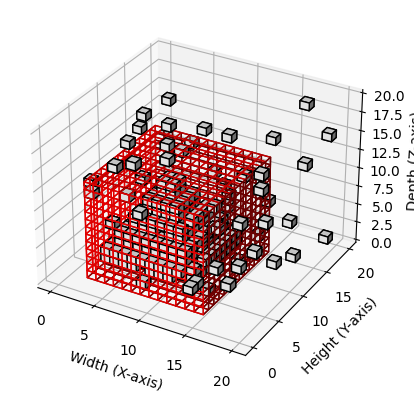

In [3]:
tensor2 = tensor_from_label("/content/drive/MyDrive/AI_Course/FinalProject/NoisyDataset2/pyramid/pyramid_2.txt")
tensor1 = return_tensor_from_path("/content/drive/MyDrive/AI_Course/FinalProject/NoisyDataset2/pyramid/pyramid_2.png")
display_3d_with_transparency(tensor1, tensor2)

generating a dataset:

In [13]:
#creating a dataset with txt labels of the 3d bbox:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt

def save_image_with_txt(tensor, folder_path, file_name, class_info, noise_level=0.007):
    image_path = os.path.join(folder_path, file_name)

    grayscale_image = tensor_to_grayscale_image(tensor)

    # Add random noise to the image
    noise1 = np.random.choice([0, 1], size=grayscale_image.shape, p=[1-noise_level, noise_level])
    noise2 = np.random.choice([0, -1], size=grayscale_image.shape, p=[0.9,0.1])
    noisy_image = np.clip(grayscale_image + noise1 + noise2, 0, 1)

    # Save the noisy image
    plt.imsave(image_path, noisy_image, cmap='gray', format='png')

    # Save the text file
    save_txt_file(folder_path, file_name, class_info)

def save_txt_file(folder_path, file_name, class_info):
    class_name, x_pos, y_pos, z_pos, width, height, depth  = class_info

    txt_path = os.path.join(folder_path, f"{os.path.splitext(file_name[:-4])[0]}.txt")
    with open(txt_path, 'w') as txt_file:
        txt_file.write(f"{class_name} {x_pos} {y_pos} {z_pos} {width} {height} {depth}")

def create_dataset_with_txt(dataset_size, path):
    classes = ["sphere", "cube", "pyramid", "stick", "torus"]
    images_per_class = dataset_size // len(classes)

    for class_name in classes:
        class_path = os.path.join(path, class_name)
        os.makedirs(class_path, exist_ok=True)

        for i in range(images_per_class):
            width, height, depth = 20, 20, 20

            if class_name == "torus":
                major_radius = random.randint(3, 8)
                minor_radius = random.randint(2, major_radius - 1)
                torus_center = np.array([random.randint(major_radius, width - major_radius - 1), random.randint(major_radius, height -major_radius - 1), random.randint(major_radius, depth-major_radius - 1)])
                torus_tensor = create_torus(width, height, depth, major_radius, minor_radius,torus_center)
                class_info = (4, torus_center[0], torus_center[1], torus_center[2] ,2*major_radius + 10, 2*major_radius + 8, major_radius+4)
                save_image_with_txt(torus_tensor, class_path, f"torus_{i}.png", class_info)

            elif class_name == "stick":
                stick_x = random.randint(0, width - 1)
                stick_y = random.randint(0, height - 1)
                stick_z = random.randint(0, depth - 1)
                length = random.randint(1, depth)
                stick_tensor = create_stick(stick_x, stick_y, stick_z, length)
                class_info = (3, stick_x, stick_y, stick_z, length+2, 3, 3)
                save_image_with_txt(stick_tensor, class_path, f"stick_{i}.png", class_info)

            elif class_name == "sphere":
                sphere_radius = random.randint(2, 8)
                sphere_center = np.array([random.randint(sphere_radius, width-sphere_radius - 1), random.randint(sphere_radius, height-sphere_radius - 1), random.randint(sphere_radius, depth-sphere_radius - 1)])
                sphere_tensor = create_sphere(width, height, depth, sphere_radius, sphere_center)
                class_info = (0, sphere_center[0], sphere_center[1], sphere_center[2], 2*sphere_radius+2, 2*sphere_radius+2, 2*sphere_radius+2)
                save_image_with_txt(sphere_tensor, class_path, f"sphere_{i}.png", class_info)

            elif class_name == "cube":
                cube_size = random.randint(5, 10)
                cube_position = np.array([random.randint(cube_size // 2, width - cube_size // 2 - 1),
                                          random.randint(cube_size // 2, height - cube_size // 2 - 1),
                                          random.randint(cube_size // 2, depth - cube_size // 2 - 1)])
                cube_tensor = create_cube(width, height, depth, cube_size, cube_position)
                class_info = (1, cube_position[0], cube_position[1], cube_position[2], cube_size+2, cube_size+2, cube_size+2)
                save_image_with_txt(cube_tensor, class_path, f"cube_{i}.png", class_info)

            elif class_name == "pyramid":
                base_width = random.randint(5, 15)
                base_position = np.array([random.randint(base_width//2, width - base_width//2 - 1),
                                          random.randint(base_width//2, height - base_width//2 - 1),
                                          random.randint(0, depth - base_width - 1)])
                pyramid_tensor = create_pyramid(width, height, depth, base_width, base_position)
                class_info = (2, base_position[0], base_position[1], base_position[2] -base_width//2-2, base_width + 2, base_width + 2, base_width +2)
                save_image_with_txt(pyramid_tensor, class_path, f"pyramid_{i}.png", class_info)

# Example usage:
dataset_size = 1000
output_path = "/content/drive/MyDrive/AI_Course/FinalProject/Dataset/test"
create_dataset_with_txt(dataset_size, output_path)

Building and training a classification model:

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score

# Define constants
image_size = (90, 90)
batch_size = 32
epochs = 10
num_classes = 5

# Define paths
train_data_dir = "/content/drive/MyDrive/AI_Course/FinalProject/train_5000_noisy"
validation_data_dir = "/content/drive/MyDrive/AI_Course/FinalProject/val_1000_noisy"
test_data_dir = "/content/drive/MyDrive/AI_Course/FinalProject/test_1000_noisy"

# Data preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False  # To maintain the order of predictions for evaluation
)

# Build the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

# Evaluate the model on the test set
test_generator.reset()
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate and print the accuracy on the test set
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Save the model
model.save("/content/drive/MyDrive/AI_Course/FinalProject/trained_model_noisy.h5")


Adding a detection layer:

In [5]:
from tensorflow.keras.models import load_model

# Load the saved model
base_model = load_model('/content/drive/MyDrive/AI_Course/FinalProject/trained_model_noisy.h5')

# Now, you can use the `pretrained_model` for classification or other tasks


In [6]:
from tensorflow.keras.models import Model

# Assuming `base_model` is your pre-trained classification model
base_model_without_softmax = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)


In [7]:
from tensorflow.keras import models, layers

# Assuming `base_model_without_softmax` is your pre-trained model without the softmax layer
# Extract the layers before the softmax layer
x = base_model_without_softmax.output

# Add your additional layers for detection
x = layers.Flatten(name='custom_flatten')(x)
x = layers.Dense(256, activation='relu', name='custom_dense')(x)
# Add more layers as needed

# Output layer for 3D bounding box coordinates (7 values for each box)
output_coords = layers.Dense(7, activation='linear', name='bbox_coords')(x)

# Create the final model
model = models.Model(inputs=base_model_without_softmax.input, outputs=output_coords)


In [8]:
def custom_detection_loss(y_true, y_pred):
    # MSE loss for bounding box coordinates
    loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return loss

model.compile(optimizer='adam', loss=custom_detection_loss)



In [23]:
def vector_from_label(txt_path):
    with open(txt_path, 'r') as txt_file:
        line = txt_file.readline().strip().split()

    # Extract values
    class_number = float(line[0])
    x_center = float(line[1])
    y_center = float(line[2])
    z_center = float(line[3])
    box_width = float(line[4])
    box_height = float(line[5])
    box_depth = float(line[6])

    # Convert to vector format
    bbox_vector = [class_number, x_center, y_center, z_center, box_width, box_height, box_depth]
    return bbox_vector

In [11]:
import tensorflow as tf

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, label_paths, batch_size):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_image_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_label_paths = self.label_paths[index * self.batch_size:(index + 1) * self.batch_size]

        batch_images = [load_image(path) for path in batch_image_paths]
        batch_labels = [vector_from_label(path) for path in batch_label_paths]

        return np.array(batch_images), np.array(batch_labels)


In [14]:
import os

def get_image_and_label_paths(dataset_path):
    image_paths = []
    label_paths = []

    # Iterate over class folders in the dataset path
    for class_folder in os.listdir(dataset_path):
        class_folder_path = os.path.join(dataset_path, class_folder)

        # Ensure it is a directory
        if os.path.isdir(class_folder_path):
            # Iterate over files in the class folder
            for file_name in os.listdir(class_folder_path):
                file_path = os.path.join(class_folder_path, file_name)

                # Check if it's a PNG image or a TXT label
                if file_name.lower().endswith('.png'):
                    image_paths.append(file_path)
                elif file_name.lower().endswith('.txt'):
                    label_paths.append(file_path)

    return image_paths, label_paths

# Define your dataset path
dataset_path = "/content/drive/MyDrive/AI_Course/FinalProject/Dataset/train"

# Get image and label paths
image_paths, label_paths = get_image_and_label_paths(dataset_path)

# Print the first few paths for verification
print("Image Paths:", image_paths[:5])
print("Label Paths:", label_paths[:5])


Image Paths: ['/content/drive/MyDrive/AI_Course/FinalProject/Dataset/train/sphere/sphere_0.png', '/content/drive/MyDrive/AI_Course/FinalProject/Dataset/train/sphere/sphere_1.png', '/content/drive/MyDrive/AI_Course/FinalProject/Dataset/train/sphere/sphere_2.png', '/content/drive/MyDrive/AI_Course/FinalProject/Dataset/train/sphere/sphere_3.png', '/content/drive/MyDrive/AI_Course/FinalProject/Dataset/train/sphere/sphere_4.png']
Label Paths: ['/content/drive/MyDrive/AI_Course/FinalProject/Dataset/train/sphere/sphere_0.txt', '/content/drive/MyDrive/AI_Course/FinalProject/Dataset/train/sphere/sphere_1.txt', '/content/drive/MyDrive/AI_Course/FinalProject/Dataset/train/sphere/sphere_2.txt', '/content/drive/MyDrive/AI_Course/FinalProject/Dataset/train/sphere/sphere_3.txt', '/content/drive/MyDrive/AI_Course/FinalProject/Dataset/train/sphere/sphere_4.txt']


In [15]:
# Define your dataset path
dataset_path = "/content/drive/MyDrive/AI_Course/FinalProject/Dataset/val"

# Get image and label paths
val_image_paths, val_label_paths = get_image_and_label_paths(dataset_path)

In [16]:
# Define your dataset path
dataset_path = "/content/drive/MyDrive/AI_Course/FinalProject/Dataset/test"

# Get image and label paths
test_image_paths, test_label_paths = get_image_and_label_paths(dataset_path)

In [17]:
def calculate_iou(y_true, y_pred):
    intersection = np.sum(np.minimum(y_true, y_pred))
    union = np.sum(np.maximum(y_true, y_pred))
    iou = intersection / union
    return iou


In [19]:
from PIL import Image
import numpy as np

def load_image(image_path):
    image = Image.open(image_path)
    # Assuming you want to convert the image to a NumPy array
    image_array = np.array(image)
    return image_array


In [24]:
batch_size = 32

data_generator = CustomDataGenerator(image_paths, label_paths, batch_size)

# Assuming your model has been defined and compiled previously
model.fit(data_generator, epochs=10)

Epoch 1/10


UnimplementedError: Graph execution error:

Detected at node model_1/conv2d/Relu defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-24-36c38fca31f7>", line 6, in <cell line: 6>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/activations.py", line 306, in relu

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5395, in relu

Fused conv implementation does not support grouped convolutions for now.
	 [[{{node model_1/conv2d/Relu}}]] [Op:__inference_train_function_1176]